## 1. Loading Libraries
This section of the code is dedicated to importing all the necessary libraries required for building and training a Convolutional Neural Network (CNN) to classify medical images, specifically X-rays. TensorFlow and Keras are imported to construct and train the neural network. The Sequential model is used for creating a linear stack of layers, and various types of layers (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, and GlobalAveragePooling2D) are included for building the CNN architecture. ImageDataGenerator is used for data augmentation, and callbacks such as EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau are used to optimize the training process. VGG16 is a pre-trained model that can be used for transfer learning. Matplotlib is used for plotting images and results, numpy for numerical operations, sklearn for performance metrics, pathlib for file path operations, and os for interacting with the operating system. Additionally, random is used for random sampling.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.image as mpimg


## 2. Preprocessing I
This code segment initializes three ImageDataGenerator objects to perform data augmentation and preprocessing on the images. The train_datagen is set up to rescale pixel values to the range [0, 1] and apply various augmentations (rotation, shifting, shearing, zooming, and flipping) to increase the diversity of the training data. The validation_datagen and test_datagen are simpler, only rescaling pixel values, as data augmentation is generally not applied to validation and test datasets.

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


## 3. Load Data
This code specifies the directory paths where the training, validation, and test datasets are stored. These paths are later used by the data generators to load the images for training and evaluation.

In [3]:
train_dir = 'dataset/train'
test_dir =  'dataset/test'
validation_dir = 'dataset/val'


## 4. Sort Cases
This function, `sort_pneumonia_images`, iterates through a specified folder, identifying and categorizing images into those depicting pneumonia caused by viruses and bacteria based on the filename. It returns two lists: one for virus images and another for bacteria images. The `plot_images` function visualizes samples from the dataset, displaying a normal case, a virus pneumonia case, and a bacteria pneumonia case. The subsequent code defines paths to dataset directories and ensures that if the pneumonia directory exists and is not empty, the images are sorted and displayed using the defined functions. This process helps in visual verification of the dataset before training the model.

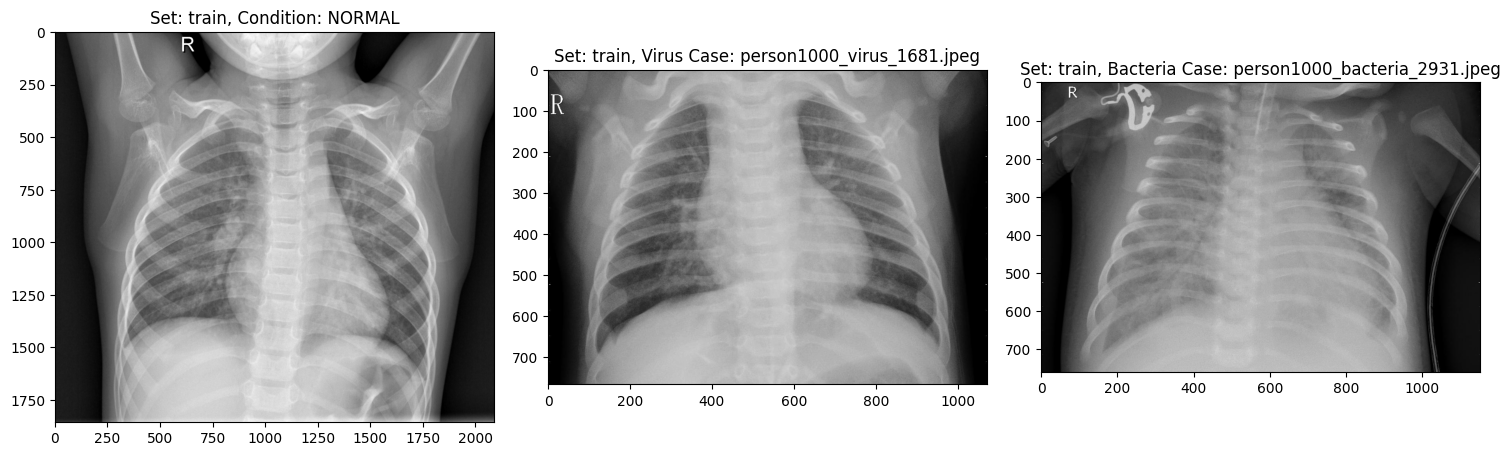

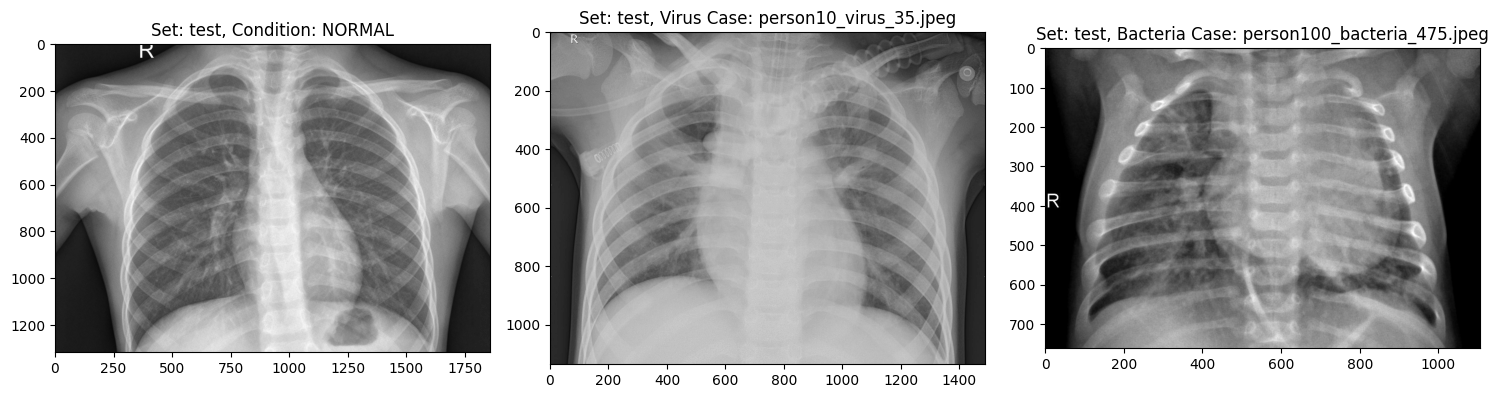

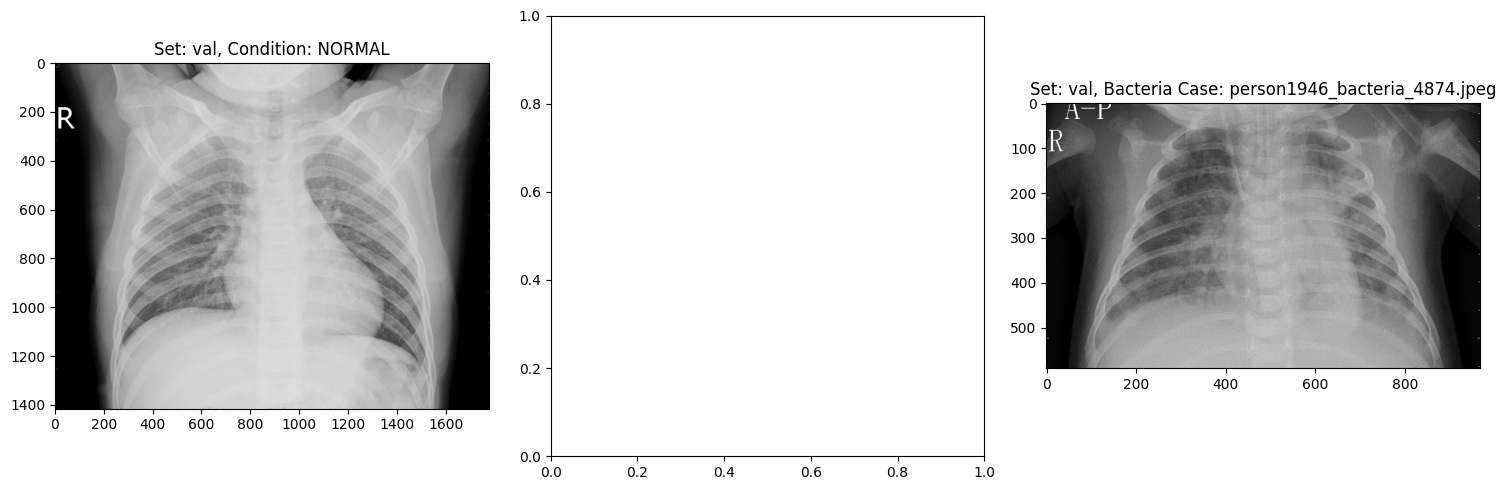

In [4]:
def sort_pneumonia_images(folder_path):
    pneumonia_virus_images = []
    pneumonia_bacteria_images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith('.jpeg'):
            file_stem = Path(filename).stem.lower()
            if 'virus' in file_stem:
                pneumonia_virus_images.append(file_path)
            elif 'bacteria' in file_stem:
                pneumonia_bacteria_images.append(file_path)

    return pneumonia_virus_images, pneumonia_bacteria_images

def plot_images(dataset_name, image_dir, pneumonia_virus_images=None, pneumonia_bacteria_images=None):
    images = [img for img in Path(image_dir).iterdir() if img.suffix.lower() == '.jpeg']

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax = ax.ravel()

    if images:
        image_path = images[0]
        ax[0].imshow(plt.imread(str(image_path)), cmap='gray')
        ax[0].set_title(f'Set: {dataset_name}, Condition: NORMAL')

        if pneumonia_virus_images:
            ax[1].imshow(plt.imread(pneumonia_virus_images[0]), cmap='gray')
            ax[1].set_title(f'Set: {dataset_name}, Virus Case: {Path(pneumonia_virus_images[0]).name}')

        if pneumonia_bacteria_images:
            ax[2].imshow(plt.imread(pneumonia_bacteria_images[0]), cmap='gray')
            ax[2].set_title(f'Set: {dataset_name}, Bacteria Case: {Path(pneumonia_bacteria_images[0]).name}')

    plt.tight_layout()
    plt.show()


dataset_paths = {
    'train': train_dir,
    'test': test_dir,
    'val': validation_dir
}

for dataset_name, dataset_path in dataset_paths.items():
    normal_dir = os.path.join(dataset_path, 'NORMAL')
    pneumonia_dir = os.path.join(dataset_path, 'PNEUMONIA')

    if os.path.exists(pneumonia_dir) and os.listdir(pneumonia_dir):
        pneumonia_virus_images, pneumonia_bacteria_images = sort_pneumonia_images(pneumonia_dir)
        plot_images(dataset_name, normal_dir, pneumonia_virus_images, pneumonia_bacteria_images)
    else:
        print(f"Warning: Directory {pneumonia_dir} does not exist or is empty")


## 5. Display Sample Data 
This function, `display_sample_images`, selects and displays five random sample images from a specified class within a directory. It ensures the selected files are valid image formats and raises an error if there are not enough images. The images are then plotted using matplotlib, which helps visually inspect the data and ensure the dataset's quality and variety before training the model.

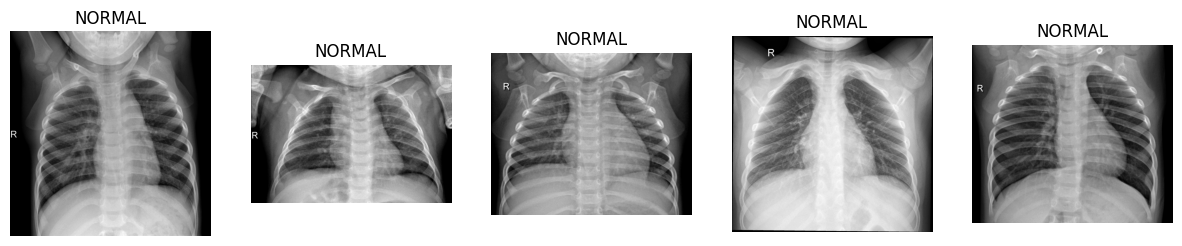

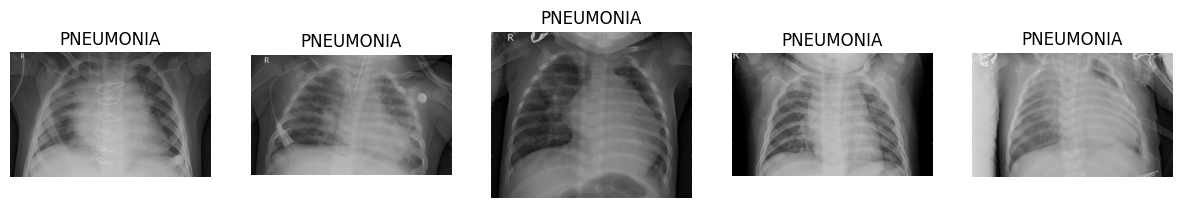

In [5]:
def display_sample_images(directory, class_name):
    class_dir = os.path.join(directory, class_name)
    
    # Filter out .DS_Store and non-image files
    valid_extensions = ('.png', '.jpg', '.jpeg')
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(valid_extensions)]
    
    if len(image_files) < 5:
        raise ValueError(f"Not enough images in {class_name} directory to display.")
    
    sample_images = random.sample(image_files, 5)
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_sample_images(train_dir, 'NORMAL')
display_sample_images(train_dir, 'PNEUMONIA')


## 6. Preprocessing II
This section initializes data generators for training, validation, and testing datasets using the previously defined ImageDataGenerator instances. It specifies the target image size (224x224 pixels), batch size, and class mode (binary classification). The train_generator includes data augmentation, while the validation_generator and test_generator simply rescale the images. The test_generator does not shuffle the data to maintain the order for evaluation consistency.

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 7. Lets Deploy A CNN Model
This section defines the architecture of the Convolutional Neural Network (CNN) using Keras' Sequential API. It starts with a convolutional layer with 32 filters, followed by max-pooling. This pattern is repeated with increasing filter sizes (64, 128). After the convolutional layers, the output is flattened and passed through a dense layer with 512 neurons and a dropout layer to prevent overfitting. Finally, a dense layer with a sigmoid activation function outputs the binary classification result. The model is then compiled using the Adam optimizer and binary cross-entropy loss function, with accuracy as the evaluation metric.

In [7]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),                                            
    Conv2D(64, (3, 3), activation='relu'),                           
    MaxPooling2D((2, 2)),                                            
    Conv2D(128, (3, 3), activation='relu'),                          
    MaxPooling2D((2, 2)),                                            
    Flatten(),                                                       
    Dense(512, activation='relu'),                                   
    Dropout(0.5),                                                    
    Dense(1, activation='sigmoid')                                   
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\m.el-hachmi-mahti\Desktop\workspace\2024\epitech\IA\T-DEV-810-TLS_5\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## 8. Lets Start Training
This section sets up the training process for the model. It defines three callbacks: EarlyStopping to halt training if the validation loss doesn't improve for 5 epochs, ModelCheckpoint to save the best model during training, and ReduceLROnPlateau to reduce the learning rate if the validation loss plateaus. The model is then trained using the fit method, specifying the training and validation data generators, number of epochs, and the callbacks to be used. The training process adjusts the model's parameters to minimize the loss and improve accuracy on the validation data.

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train 
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20


c:\Users\m.el-hachmi-mahti\Desktop\workspace\2024\epitech\IA\T-DEV-810-TLS_5\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.7381 - loss: 0.7557 - val_accuracy: 0.7500 - val_loss: 0.5414 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.8518 - loss: 0.3222 - val_accuracy: 0.6250 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8544 - loss: 0.3207 - val_accuracy: 0.6250 - val_loss: 0.9560 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.8754 - loss: 0.2793 - val_accuracy: 0.6250 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8972 - loss: 0.2487 - val_accuracy: 0.7500 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8987 - loss: 0.2459 - val_accuracy: 0.6875 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9025 - loss: 0.2303 - val_

## 9. Model Evaluation  

### A. model summary
This command prints a detailed summary of the model architecture. It includes the names and types of each layer, their output shapes, the number of parameters in each layer, and the total number of trainable and non-trainable parameters. This summary helps in understanding the structure and complexity of the model, ensuring all layers are correctly configured and providing insight into the model's capacity and depth.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,189,829 (508.08 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,793,220 (338.72 MB)

### B. Confusion Matrix
This section evaluates the trained model on the test dataset and generates a confusion matrix to visualize the performance. The test generator is reset to ensure a fresh evaluation. True labels are retrieved, and predictions are made by the model. Predicted probabilities are converted to binary class labels. A confusion matrix is then created to compare true labels with predicted labels, and it's displayed using matplotlib. This matrix provides a clear view of the model's classification performance, showing how many instances were correctly and incorrectly classified for each class.

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step


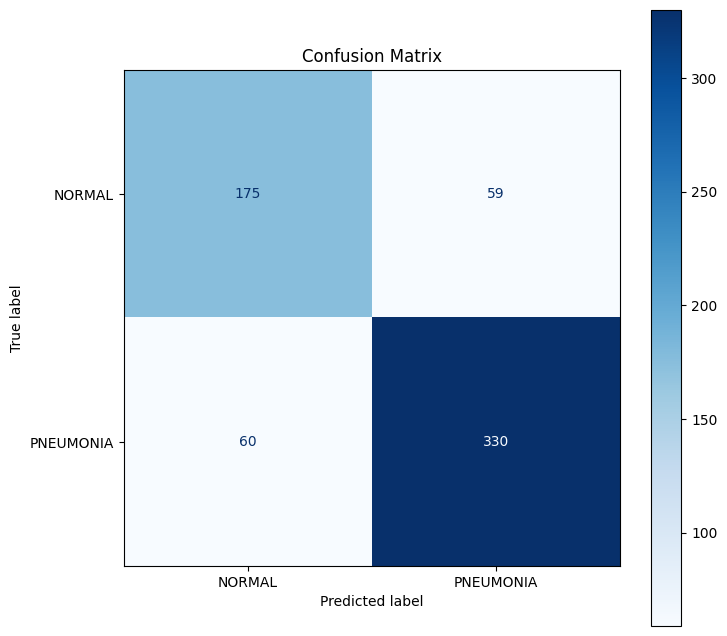

In [10]:
# Ensure the test generator is reset
test_generator.reset()

# Get the true labels and predictions
test_labels = test_generator.classes
test_pred_prob = model.predict(test_generator)
test_pred_classes = (test_pred_prob > 0.5).astype("int32").flatten()

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

# Plot confusion matrix and save as PNG
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


### C. Classification Report
This part generates and prints a classification report, which provides detailed metrics of the model's performance on the test set. It includes precision, recall, F1-score, and support for each class. These metrics give a comprehensive understanding of the model's strengths and weaknesses in classifying each class, beyond what is evident from the confusion matrix alone. The classification report helps in identifying any bias towards a particular class and in assessing the overall effectiveness of the model.

In [11]:
report = classification_report(test_labels, test_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.74      0.75      0.75       234
   PNEUMONIA       0.85      0.85      0.85       390

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.81      0.81      0.81       624



### C. Save Model
This command saves the trained model to a file named 'xray_model.h5'. Saving the model allows it to be loaded later for making predictions without retraining, which is useful for deployment and further evaluation. The saved model includes the architecture, weights, and training configuration, ensuring that it can be fully restored and used in future applications.

In [12]:
# Save the model in HDF5 format
model.save('model_v2.h5')